In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def simulate_gbm(S0, mu, sigma, T, dt, n_paths=1):
    """
    Simulate Geometric Brownian Motion (GBM) paths.
    Returns: t (1D array, length n_steps+1), S (2D array shape (n_steps+1, n_paths))
    """
    n_steps = int(np.round(T / dt))
    t = np.linspace(0, T, n_steps + 1)
    dW = np.random.normal(0.0, np.sqrt(dt), size=(n_steps, n_paths))
    W = np.vstack([np.zeros(n_paths), dW.cumsum(axis=0)])
    X = (mu - 0.5 * sigma**2) * t[:, None] + sigma * W
    S = S0 * np.exp(X)
    return t, S

In [2]:
def european_option_mc(S0, K, T, r, sigma, dt, n_paths, option_type='call', seed=None):
    """
    Price a European option by Monte Carlo (using terminal stock price from GBM).
    option_type: 'call' or 'put'
    Returns: price (float)
    """
    if seed is not None:
        np.random.seed(seed)
    _, S = simulate_gbm(S0, r, sigma, T, dt, n_paths)
    ST = S[-1]
    if option_type == 'call':
        payoff = np.maximum(ST - K, 0.0)
    else:
        payoff = np.maximum(K - ST, 0.0)
    price = np.exp(-r * T) * np.mean(payoff)
    se = np.exp(-r * T) * np.std(payoff, ddof=1) / np.sqrt(n_paths)
    return price, se

In [3]:
def black_scholes_price(S0, K, T, r, sigma, option_type='call'):
    """
    Black-Scholes price for European call or put (non-dividend paying stock).
    """
    if T <= 0:
        if option_type == 'call':
            return max(S0 - K, 0.0)
        else:
            return max(K - S0, 0.0)
    sqrtT = np.sqrt(T)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT
    if option_type == 'call':
        price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return price

In [4]:
def black_scholes_greeks(S0, K, T, r, sigma, option_type='call'):
    """
    Returns a dictionary with analytical Greeks: Delta, Gamma, Vega, Theta (per-year).
    Note: Theta here is standard continuous-time Theta (price change per year).
    """
    sqrtT = np.sqrt(max(T, 1e-16))
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT
    pdf_d1 = norm.pdf(d1)
    if option_type == 'call':
        delta = norm.cdf(d1)
    else:
        delta = norm.cdf(d1) - 1.0
    gamma = pdf_d1 / (S0 * sigma * sqrtT)
    vega = S0 * pdf_d1 * sqrtT
    theta_call = -(S0 * pdf_d1 * sigma) / (2 * sqrtT) - r * K * np.exp(-r * T) * norm.cdf(d2)
    if option_type == 'call':
        theta = theta_call
    else:
        theta_put = -(S0 * pdf_d1 * sigma) / (2 * sqrtT) + r * K * np.exp(-r * T) * norm.cdf(-d2)
        theta = theta_put
    return {'Delta': delta, 'Gamma': gamma, 'Vega': vega, 'Theta': theta}

Parameters: S0=100.0, K=105.0, T=1.0, r=0.05, sigma=0.2
Monte Carlo Call: 7.976971  (SE ≈ 0.041564)
Black-Scholes Call: 8.021352

Monte Carlo Put:  7.929263  (SE ≈ 0.032831)
Black-Scholes Put:  7.900442

Call Greeks (analytic):
  Delta: 0.542228
  Gamma: 0.019835
  Vega: 39.670524
  Theta: -6.277126


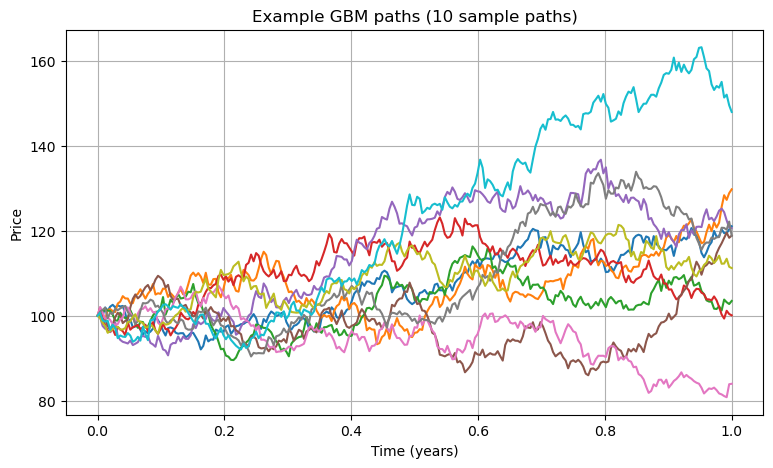

In [5]:
if __name__ == "__main__":
    S0 = 100.0
    K = 105.0
    T = 1.0
    r = 0.05
    sigma = 0.2
    dt = 1/252
    n_paths = 100_000
    seed = 12345

    mc_call_price, mc_se = european_option_mc(S0, K, T, r, sigma, dt, n_paths, option_type='call', seed=seed)
    mc_put_price, mc_se_put = european_option_mc(S0, K, T, r, sigma, dt, n_paths, option_type='put', seed=seed+1)

    bs_call = black_scholes_price(S0, K, T, r, sigma, option_type='call')
    bs_put = black_scholes_price(S0, K, T, r, sigma, option_type='put')

    greeks_call = black_scholes_greeks(S0, K, T, r, sigma, option_type='call')

    print("Parameters: S0={}, K={}, T={}, r={}, sigma={}".format(S0, K, T, r, sigma))
    print(f"Monte Carlo Call: {mc_call_price:.6f}  (SE ≈ {mc_se:.6f})")
    print(f"Black-Scholes Call: {bs_call:.6f}")
    print()
    print(f"Monte Carlo Put:  {mc_put_price:.6f}  (SE ≈ {mc_se_put:.6f})")
    print(f"Black-Scholes Put:  {bs_put:.6f}")
    print()
    print("Call Greeks (analytic):")
    for name, val in greeks_call.items():
        print(f"  {name}: {val:.6f}")
    np.random.seed(42)
    t, S = simulate_gbm(S0, r, sigma, T, dt, n_paths=10)
    plt.figure(figsize=(9,5))
    plt.plot(t, S)
    plt.title("Example GBM paths (10 sample paths)")
    plt.xlabel("Time (years)")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()